In [1]:
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio.features
import segment_anything
import segmenteverygrain as seg
import skimage
import shapely
import tensorflow.keras as keras
%matplotlib widget

2024-11-17 13:36:41.837356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 13:36:42.257560: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 13:36:44.180852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
class Grain(object):
    """ Stores grain information and plot representation """
    
    REGION_PROPS = [
        'label',
        'area',
        'centroid',
        'major_axis_length',
        'minor_axis_length', 
        'orientation',
        'perimeter',
        'max_intensity',
        'mean_intensity',
        'min_intensity'
    ]

    def __init__(self, xy:list=[], data:pd.Series=None):
        # Data
        self.xy = xy
        self.data = data

        # Display
        self.normal_props = {
            'alpha': 0.6
        }
        self.selected_props = {
            'alpha': 1.0,
            'facecolor': 'lime'
        }
        self.patch = None
        self.selected = False

    def get_polygon(self) -> shapely.Polygon:
        return shapely.Polygon(self.patch.get_path().vertices)

    def make_data(self, ax) -> pd.Series:
        # Get image and labeled region
        image = ax.get_images()[0].get_array()
        label = rasterio.features.rasterize([self.get_polygon()], out_shape=image.shape[:2])
        # Calculate region properties
        # TODO: Avoid going list -> DataFrame -> Series
        data = skimage.measure.regionprops_table(
            label, intensity_image=image, properties=self.REGION_PROPS)
        self.data = pd.DataFrame(data).iloc[0]
        # print('New grain:', self.data)
        return self.data

    def make_patch(self, ax):
        # Create patch
        (self.patch,) = ax.fill(
            *self.xy,
            edgecolor='black',
            linewidth=5.0,
            picker=True,
            **self.normal_props
        )
        # Save original color (for select/unselect)
        self.normal_props['facecolor'] = self.patch.get_facecolor()
        # Compute grain data if not provided
        if self.data is None:
            self.data = self.make_data(ax)
        return self.patch

    def select(self):
        self.selected = ~self.selected
        props = self.selected_props if self.selected else self.normal_props
        if self.selected: 
            print(self.data)
        self.patch.set(**props)
        return self.selected


class GrainPlot(object):
    """ Interactive plot to create, delete, and merge grains """

    def __init__(self, grains, image=None, predictor=None):
        # Input
        self.grains = grains
        self.image = image
        self.predictor = predictor
        # Plot
        self.last_pick = None
        self.fig = plt.figure(figsize=(6, 4))
        self.canvas = self.fig.canvas
        self.ax = self.fig.add_subplot(aspect='equal', xticks=[], yticks=[])
        if isinstance(image, np.ndarray):
            self.ax.imshow(image)
            print(self.ax.get_images()[0].get_array().shape)
            self.ax.autoscale(enable=False)
        # Interaction events
        self.cids = []
        self.created_grains = []
        self.selected_grains = []
        self.left_cursor = patches.Circle((10, 10), radius=5, color='lime', visible=False)
        self.right_cursor = patches.Circle((10, 10), radius=5, color='red', visible=False)
        self.events = {
            'button_press_event': self.onclick,
            'pick_event': self.onpick,
            'key_press_event': self.onpress
        }
        # Draw elements on plot without updating after each one
        self.fig.tight_layout()
        with plt.ioff():
            for grain in grains:
                grain.make_patch(self.ax)
            self.ax.add_patch(self.left_cursor)
            self.ax.add_patch(self.right_cursor)
        # Seems to help with occasional failure to draw updates
        plt.pause(0.1)

    # Helper functions ---
    def set_cursor(self, cursor, xy):
        if xy:
            cursor.set_center(xy)
            cursor.set_visible(True)
        else:
            cursor.set_visible(False)

    def unselect_cursors(self):
        self.set_cursor(self.left_cursor, False)
        self.set_cursor(self.right_cursor, False)

    def unselect_grains(self):
        for grain in self.selected_grains:
            grain.select()
        self.selected_grains = []

    def unselect_all(self):
        self.unselect_cursors()
        self.unselect_grains()

    # Manage grains ---
    def create_grain(self):
        """ Attempt to find and add grain at selected point """
        # Verify that we've actually selected something
        if not self.left_cursor.get_visible():
            return
        # Two-point prompt (grain and background)
        xy1 = self.left_cursor.get_center()
        if self.right_cursor.get_visible():
            xy2 = self.right_cursor.get_center()
            x, y = seg.two_point_prompt(*xy1, *xy2, image=self.image, predictor=self.predictor)
        # One-point prompt (grain only)
        else:
            x, y, mask = seg.one_point_prompt(*xy1, image=self.image, predictor=self.predictor)
        # Record new grain on plot, list of grains, and list of created grains (for undo)
        grain = Grain((x, y))
        grain.make_patch(self.ax)
        self.grains.append(grain)
        self.created_grains.append(grain)
        # Reset cursors
        self.unselect_cursors()

    def delete_grains(self):
        """ Delete all selected grains """
        with plt.ioff():
            for grain in self.selected_grains:
                # Remove grain patch
                grain.patch.remove()
                # Remove grain data
                self.grains.remove(grain)
                if grain in self.created_grains:
                    self.created_grains.remove(grain)
        self.selected_grains = []

    def merge_grains(self):
        """ Merge all selected grains """
        # Verify there are at least two grains to merge
        if len(self.selected_grains) < 2:
            return
        # Find vertices of merged grains using Shapely
        polys = [g.get_polygon() for g in self.selected_grains]
        poly = shapely.unary_union(polys)
        # Verify grains actually overlap, otherwise reject selections
        if isinstance(poly, shapely.MultiPolygon):
            self.unselect_grains()
            return
        # Make new merged grain
        new_grain = Grain(poly.exterior.xy)
        self.grains.append(new_grain)
        self.created_grains.append(new_grain)
        new_grain.make_patch(self.ax)
        # Clear old constituent grains
        self.delete_grains()

    def undo_grain(self):
        # Verify that there is a grain to undo
        if len(self.created_grains) < 1:
            return
        # Select and remove latest grain
        self.unselect_all()
        self.selected_grains = [self.created_grains[-1]]
        self.delete_grains()

    # Events ---
    def onclick(self, event):
        """ Handle clicking anywhere on plot """
        # Only individual clicks, only if not handled by onpick, only when no grains selected
        if event.dblclick is True or event is self.last_pick or len(self.selected_grains) > 0:
            return
        # Left click: set grain prompt
        if event.button == 1:
            self.set_cursor(self.left_cursor, (event.xdata, event.ydata))
        # Right click: set background prompt
        elif event.button == 3:
            self.set_cursor(self.right_cursor, (event.xdata, event.ydata))

    def onpick(self, event):
        """ Handle clicking on an existing grain """
        # Only individual left-clicks
        mouseevent = event.mouseevent
        if mouseevent.dblclick or mouseevent.button != 1:
            return
        # Tell onclick to ignore this event
        self.last_pick = mouseevent
        # Hide cursors
        self.unselect_cursors()
        # Add selected grain to selection list
        for grain in self.grains:
            if event.artist is grain.patch:
                if grain.select():
                    self.selected_grains.append(grain)
                else:
                    self.selected_grains.remove(grain)
                break
    
    def onpress(self, event):
        """ Handle key presses """
        if event.key == 'c':
            self.create_grain()
        elif event.key == 'd' or event.key == 'delete':
            self.delete_grains()
        elif event.key == 'm':
            self.merge_grains()
        elif event.key == 'z':
            self.undo_grain()
        elif event.key == 'escape':
            self.unselect_all()
        # TODO: Handle occasional drawing failures by forcing a GUI update
        # elif event.key == 'f':
        #     bg = self.canvas.copy_from_bbox(self.fig.bbox)
        #     self.canvas.restore_region(bg)
        #     self.canvas.blit(self.fig.bbox)
        #     # self.canvas.draw()
        #     self.canvas.flush_events()

    def activate(self):
        """ Enable interactive features """
        for event, handler in self.events.items():
            self.cids.append(self.canvas.mpl_connect(event, handler))

    def deactivate(self):
        """ Disable interactive features """
        for cid in self.cids:
            self.canvas.mpl_disconnect(cid)
        self.cids = []
    
    # Output ---
    def get_mask(self):
        all_grains = [g.get_polygon() for g in self.grains]
        return seg.create_labeled_image(all_grains, self.image)

    def get_data(self) -> pd.DataFrame:
        return pd.concat([g.data for g in self.grains], axis=1).T


segmenting image tiles...


100%|██████████| 1/1 [00:00<00:00, 13706.88it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

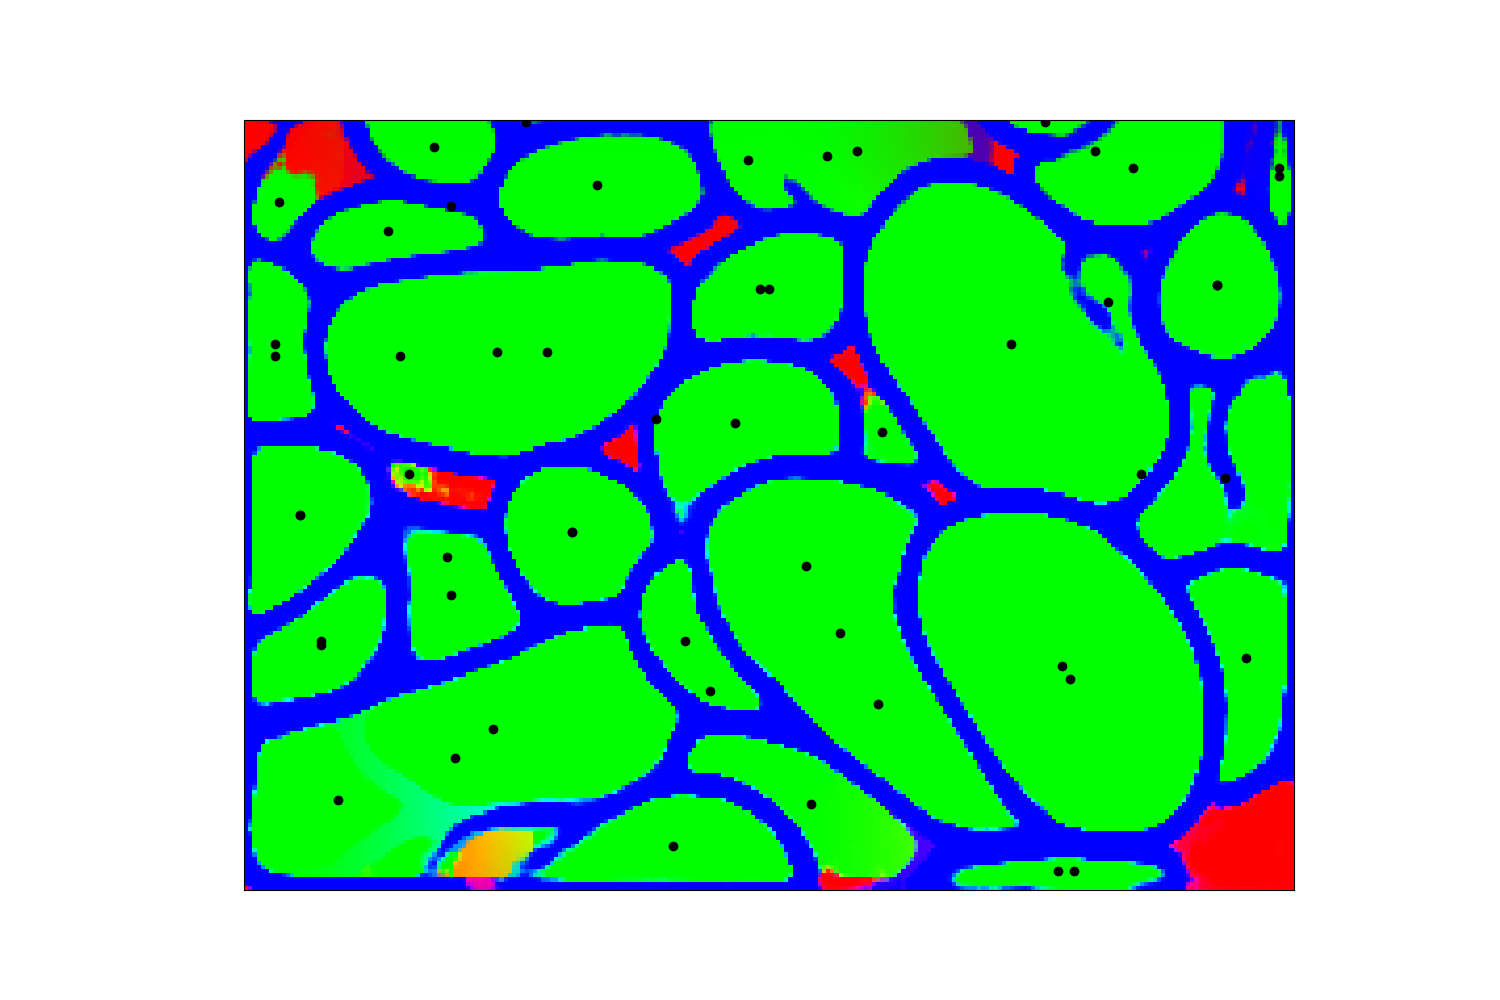

In [3]:
# Load models
model = seg.Unet()
model.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=seg.weighted_crossentropy,
    metrics=["accuracy"])
model.load_weights('./segmenteverygrain/checkpoints/seg_model')
sam = segment_anything.sam_model_registry["default"](checkpoint="./sam_vit_h_4b8939.pth")

# Load image
fname = './torrey_pines_small.jpeg'
image = np.array(keras.preprocessing.image.load_img(fname))

# Unet prediction
image_pred = seg.predict_image(image, model, I=256)
labels, coords = seg.label_grains(image, image_pred, dbs_max_dist=20.0)
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(image_pred)
plt.scatter(np.array(coords)[:,0], np.array(coords)[:,1], c='k')
plt.xticks([])
plt.yticks([])

In [4]:
# SAM segmentation
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(
    sam, image, image_pred, coords, labels, 
    min_area=400.0, plot_image=False, remove_edge_grains=False, remove_large_objects=False
)

creating masks using SAM...


100%|██████████| 54/54 [00:08<00:00,  6.70it/s]


finding overlapping polygons...


54it [00:00, 130.41it/s]


finding best polygons...


100%|██████████| 19/19 [00:00<00:00, 81.83it/s]


creating labeled image...


In [5]:
# TODO: this already happens in sam_segmentation!
predictor = segment_anything.SamPredictor(sam)
predictor.set_image(image)

(184, 251, 3)


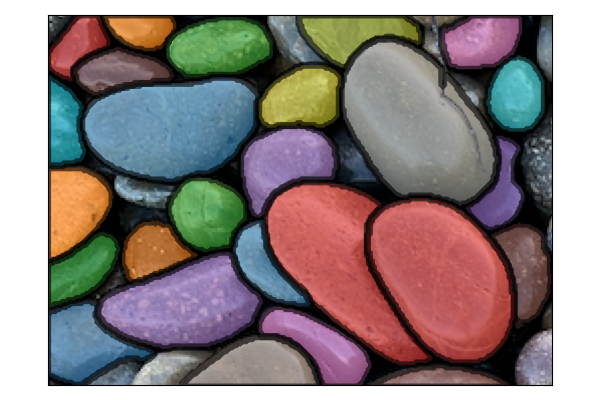

label                  18.000000
area                 4404.000000
centroid-0             53.452316
centroid-1            182.487511
major_axis_length      95.023016
minor_axis_length      59.613415
orientation             0.707635
perimeter             269.078210
max_intensity-0       255.000000
max_intensity-1       255.000000
max_intensity-2       249.000000
mean_intensity-0      164.754087
mean_intensity-1      167.800409
mean_intensity-2      158.948456
min_intensity-0         0.000000
min_intensity-1         0.000000
min_intensity-2         1.000000
Name: 17, dtype: float64
New grain: label                   1.000000
area                 4410.000000
centroid-0             53.421088
centroid-1            182.505896
major_axis_length      94.967147
minor_axis_length      59.688683
orientation             0.706761
perimeter             259.078210
max_intensity-0       255.000000
max_intensity-1       255.000000
max_intensity-2       249.000000
mean_intensity-0      164.637415
mean_in

In [32]:
# Plot grains
grains = [Grain(p.exterior.xy, row[1]) for p, row in zip(all_grains, grain_data.iterrows())]
grain_plot = GrainPlot(grains, image=image, predictor=predictor)
grain_plot.activate()

In [ ]:
import pandas as pd

grain_plot.deactivate()
rows = [g.data for g in grain_plot.grains]
new_grain_data = grain_plot.get_data()
print(new_grain_data.head())

n_of_units = 1000
units_per_pixel = n_of_units/1552.77 # length of scale bar in pixels
for col in ['major_axis_length', 'minor_axis_length', 'perimeter', 'area']:
    new_grain_data[col] *= units_per_pixel

new_grain_data.to_csv(fname[:-4] + '.csv')
fig, ax = seg.plot_histogram_of_axis_lengths(new_grain_data['major_axis_length']/1000, new_grain_data['minor_axis_length']/1000)

In [ ]:
# Save mask with original image for training
dirname = './images/'
outname = dirname + fname.split('/')[-1].split('.')[-2]
rasterized_image, mask = grain_plot.get_mask()
cv2.imwrite(outname + '_mask.png', mask)
cv2.imwrite(outname + '_verify.png', mask*127)
cv2.imwrite(outname + '_image.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))